# Solving the HJB equation on p26 of HS_notes_53

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy.matrices import *
from sympy.solvers import solve
from sympy import Symbol
import scipy
from scipy.optimize import fsolve
from scipy.integrate import odeint
from math import sqrt
%matplotlib inline

### 7.1 Parametric Inputs

The VAR estimates imply:
$$\hat \alpha_y = 0.386, \hat \alpha_z = 0, \hat \beta = 1, \hat \kappa = 0.019, \sigma_y = \begin{bmatrix} 0.488 \\ 0\end{bmatrix}, \sigma_z = \begin{bmatrix} 0.013 \\ 0.028\end{bmatrix}  $$
We assume that $\delta = 0.002$

Let $\sigma = \begin{bmatrix} \sigma_y' \\ \sigma_z' \end{bmatrix}$

In [2]:
# Predetermined parameter values
alpha_y = 0.386
alpha_z = 0
beta = 1
kappa = 0.019
sigma_y = np.array([[0.488],[0]])
sigma_z = np.array([[0.013],[0.028]])
delta = 0.002
sigma = np.vstack((sigma_y.T,sigma_z.T))

# Useful objects
sigmahat = np.linalg.inv(sigma).T.dot(np.linalg.inv(sigma))
norm = Matrix(sigma_z).norm()**2
sigma_det = np.linalg.det(sigmahat)

We also need to choose a value for q and $\theta$:

In [3]:
# Chosen parameter values
q = 0.05
theta = 0.1541

### Step 1: Find $\beta= f^-(\kappa)$ and $\beta = f^+(\kappa)$

Letting $\alpha_y = \hat \alpha_y$ and $\alpha_z = \hat \alpha_z$, the parametric formula for relative entropy is:

$$ \epsilon(M^R) = \frac{1}{2}|\sigma^{-1} \begin{bmatrix} \beta - \hat \beta \\ \hat \kappa - \kappa \end{bmatrix}|^2 \frac{|\sigma_z|^2}{2\kappa}$$

For a given $\kappa$, setting this equal to $\frac{1}{2}q^2$ gives a quadratic equation in $\beta$. We take the high $\beta$ solution when $\kappa < \hat \kappa$ and the low $\beta$ solution when $\kappa > \hat \kappa$. We express this as two functions: $\beta = f^-(\kappa)$ for $\kappa < \hat \kappa$ and $\beta = f^+(\kappa)$ for $\kappa > \hat \kappa$.

I have solved two ways. A slow way using Sympy, and a faster way using an analytic solution that Yiran showed me. I check that both methods give the same solutions

In [4]:
#Functions which find beta as a function of k using Sympy

def f_minus(k):
    #Create the vectors:
    b = Symbol('b')
    vec1 = Matrix([[b-beta],[kappa-k]])

    #Create the components of the equation to be solved for beta
    eq = ((Matrix(sigma_z).norm()**2)/(4*k))*((Matrix(sigma).inv()*vec1)[0]**2 + (Matrix(sigma).inv()*vec1)[1]**2) - 0.5*q**2

    return solve(eq,b)[1]

def f_plus(k):
    #Create the vectors:
    b = Symbol('b')
    vec1 = Matrix([[b-beta],[kappa-k]])

    #Create the components of the equation to be solved for beta
    eq = ((Matrix(sigma_z).norm()**2)/(4*k))*((Matrix(sigma).inv()*vec1)[0]**2 + (Matrix(sigma).inv()*vec1)[1]**2) - 0.5*q**2

    return solve(eq,b)[0]

In [5]:
# Yiran's analytic solution

def f_minus2(k):
    return beta + (-sigmahat[0,1]*(kappa-k)+sqrt(-(kappa-k)**2*sigma_det + (2*sigmahat[0,0]*q**2*k/norm)))/sigmahat[0,0]

def f_plus2(k):
    return beta + (-sigmahat[0,1]*(kappa-k)-sqrt(-(kappa-k)**2*sigma_det + (2*sigmahat[0,0]*q**2*k/norm)))/sigmahat[0,0]

In [6]:
#Check that they are the same
f_minus(0.03)-f_minus2(0.03),f_plus(0.03)-f_plus2(0.03)

(-4.44089209850063e-16, 3.33066907387547e-16)

### Step 2: Find $v^-$ and $v^+$

We solve three equations in three unknowns:
$$ (-\delta - \kappa)v^- + 0.01\beta = 0 $$
$$ \beta - f^-(\kappa) = 0 $$
$$ 0.01 \frac{df^-}{d\kappa}(\kappa) - v^- = 0 $$

Substituting gives an equation which is just a function of $\kappa$:

$$ (-\delta - \kappa)\frac{df^-}{d\kappa}(\kappa) + f^-(\kappa) = 0$$

We use the Brentq algorithm to find the value of $\kappa$ that satisfies this equation, and then calculate $v^-$ using the third equation.

Analogously, to calculate $v^+$ we use:
$$ (-\delta - \kappa)\frac{df^+}{d\kappa}(\kappa) + f^+(\kappa) = 0$$
and $$ 0.01 \frac{df^+}{d\kappa}(\kappa) - v^+ = 0 $$

In [7]:
def tosolve1(k):
    return f_minus2(k) -(delta+k)*scipy.misc.derivative(f_minus2, k, dx = 0.000001)
def tosolve2(k):
    return f_plus2(k) -(delta+k)*scipy.misc.derivative(f_plus2, k, dx = 0.000001)

For Scipy's brentq algorithm you need to specify a value where the function is positive and one where it is negative - they Scipy finds one in the middle which set the function equal to zero.

To implement this, I manually find the domain of the $f^-(\kappa)$ function (which is the same as for the $f^+(\kappa)$ function):

In [8]:
f_minus2(0.0115)

1.0659567853329261

In [9]:
f_minus2(0.0114)

ValueError: math domain error

In [10]:
f_minus2(0.0315)

0.93281932468234929

In [11]:
f_minus2(0.0316)

ValueError: math domain error

We can then find $v^-$ and $v^+$:

In [12]:
v_minus = 0.01*scipy.misc.derivative(f_minus2, scipy.optimize.brentq(tosolve1,0.0115,0.0315), dx = 0.000001)
v_plus = 0.01*scipy.misc.derivative(f_plus2, scipy.optimize.brentq(tosolve2,0.0115,0.0315), dx = 0.000001)

In [13]:
v_minus,v_plus

(0.7905559431831134, 0.26411887303567916)

### Step 3: Find $\kappa$ as a function of $\frac{dv}{dz}$

To solve the ODEs, we need to know the value of $\kappa$ which minimizes the HJB equation, for a given value of $\frac{dv}{dz}(z)$ This value of $\kappa$ satisfies:

$$ 0.01\frac{df^-}{d \kappa}(\kappa) - \frac{dv}{dz}(z) = 0 $$ when z < 0 and
$$ 0.01\frac{df^+}{d \kappa}(\kappa) - \frac{dv}{dz}(z) = 0 $$ when z > 0.

For this, I use an analytic solution that Yiran showed me. However, I also verify his method using a much slower root-finding method that I was using previously.

In [14]:
# Yiran's analytic solution

def k_star_minus(dv):
    N = (sigmahat[0,0]*dv/0.01 - sigmahat[0,1])**2
    A = sigma_det*(N + sigma_det)
    B = -(2*sigmahat[0,0]*q**2)/norm*(N + sigma_det) - 2*kappa*sigma_det*(N + sigma_det)
    C = sigma_det*(N + sigma_det)*kappa**2 + (sigmahat[0,0]**2)*(q**4)/(norm**2) + 2*sigmahat[0,0]*(q**2)*kappa*sigma_det/norm
    return (-B - sqrt(B**2 - 4*A*C))/(2*A)

def k_star_plus(dv):
    N = (sigmahat[0,0]*dv/0.01 - sigmahat[0,1])**2
    A = sigma_det*(N + sigma_det)
    B = -(2*sigmahat[0,0]*q**2)/norm*(N + sigma_det) - 2*kappa*sigma_det*(N + sigma_det)
    C = sigma_det*(N + sigma_det)*kappa**2 + (sigmahat[0,0]**2)*(q**4)/(norm**2) + 2*sigmahat[0,0]*(q**2)*kappa*sigma_det/norm
    return (-B + sqrt(B**2 - 4*A*C))/(2*A)

In [15]:
#Root finding method to verify Yiran's algebra:

def func1(k):
        return 0.01*scipy.misc.derivative(f_minus, k, dx = 0.000001) - 0.3
k_star1 = scipy.optimize.brentq(func1,0.0115,0.0315) #Reduce tol to speed up

def func2(k):
        return 0.01*scipy.misc.derivative(f_plus, k, dx = 0.000001) - 0.3
k_star2 = scipy.optimize.brentq(func2,0.0115,0.0315) #Reduce tol to speed up

In [16]:
#Check that they are the same
k_star1-k_star_minus(0.3), k_star2 - k_star_plus(0.3)

(3.48728169605184e-10, -3.48720965298588e-10)

### Step 4: Solve the two ODEs

With this value of $\kappa^*$ that minimizes the HJB equation, we can now solve the HJB equations:

$$ 0 = -\delta v(z) + 0.01(\hat \alpha_y + f^-(\kappa^*)z) - z \kappa^* \frac{dv}{dz}(z) + \frac{1}{2}|\sigma_z|^2 \frac{d^2v}{dz^2}(z) - \frac{1}{2\theta} \begin{bmatrix} 0.01 \, \frac{dv}{dz}(z) \end{bmatrix} \sigma \sigma' \begin{bmatrix} 0.01 \\ \frac{dv}{dz}(z) \end{bmatrix} $$

(there is an analogous equation for z > 0)

To solve this ODE, we impose Neumann conditions, using the values of $v^-$ and $v^+$ found in Step 2.

In particular, we set $v'(z^-) = v^-$ and $v'(z^+) = v^+$ where $z^-$ and $z^+$ are the lower and upper end of the grid which we solve v(z) over.

We also impose that both ODEs give the same solutions for v(0) and v'(0).


In [17]:
# Grid over which to solve the two ODEs
z_space1 = np.linspace(-5,0,200)
z_space2 = np.linspace(5,0,200)

To solve using Scipy, I need to convert the second-order ODE into a system of first-order ODEs. This is done below:

In [18]:
def deriv_minus(y, z):
    f, phi = y
    vec = np.hstack((0.01,phi))
    return [phi, 2/norm*(delta*f - 0.01*(alpha_y + f_minus2(k_star_minus(phi))*z) + z*k_star_minus(phi)*phi + (1/(2*theta))*vec.dot(sigma).dot(sigma.T).dot(vec.T))]

def deriv_plus(y, z):
    f, phi = y
    vec = np.hstack((0.01,phi))
    return [phi, 2/norm*(delta*f - 0.01*(alpha_y + f_plus2(k_star_plus(phi))*z) + z*k_star_plus(phi)*phi + (1/(2*theta))*vec.dot(sigma).dot(sigma.T).dot(vec.T))]

I then create a function which returns the difference between v(0) and v'(0) for each of the two ODEs. This is a function of a guess of $v(z^-)$ and $v(z^+)$:

In [19]:
# For a given guess of v at z- and z+, this returns the difference between each v(0) and each v'(0)
def v_at_zero(a) :
    sol1 = scipy.integrate.odeint(deriv_minus, [a[0], v_minus],z_space1)
    sol2 = scipy.integrate.odeint(deriv_plus, [a[1], v_plus],z_space2)
    return sol1[-1,0] - sol2[-1,0], sol1[-1,1] - sol2[-1,1]

Using the above function, we can find the values of of $v(z^-)$ and $v(z^+)$ that make both ODEs match in terms of v(0) and v'(0):

In [20]:
# Find the initial conditions which make v(0) and v'(0) match
# The initial guess must be well chosen, as there are values for which scipy.integrate.odeint returns an error
a = scipy.optimize.root(v_at_zero, [-3.2,1.5] )

In [21]:
a.x[0],a.x[1]

(-3.1933998363540175, 2.2701770807652855)

Using the initial conditions that we found, we can then plot our solution of v(z) and $\frac{dv}{dz}(z)$:

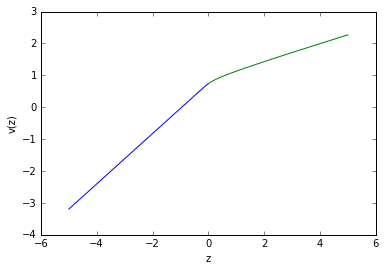

In [22]:
sol1 = scipy.integrate.odeint(deriv_minus, [a.x[0], v_minus],z_space1)
sol2 = scipy.integrate.odeint(deriv_plus, [a.x[1], v_plus],z_space2)

plt.plot(z_space1,sol1[:,0])
plt.plot(z_space2,sol2[:,0])

plt.ylabel('v(z)')
plt.xlabel('z')

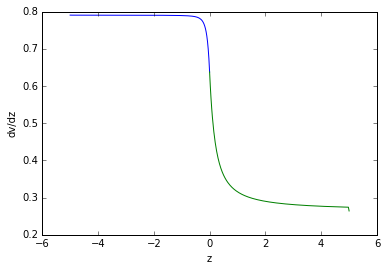

In [23]:
plt.plot(z_space1,sol1[:,1])
plt.plot(z_space2,sol2[:,1])

plt.ylabel('dv/dz')
plt.xlabel('z')

There is something a bit strange going on with dv/dz at the top end. However, it seems to be less of an issue the larger I make $z^+$ (it was a bigger jump with $z^+ = 2$). It also does not appear to affect the rest of the solution.